In [31]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import accelerate
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from imblearn.metrics import geometric_mean_score

# Data

In [2]:
train_df = pd.read_csv("../../data/processed/train.csv",index_col=0)
train_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type
9604.0,"If Emily passes her driving test, her best fri...",Emily has a best friend.,E,type5_possessive
9605.0,It's not the case that if Emily passes her dri...,Emily has a best friend.,E,type5_possessive
9606.0,Sam believes that if Emily passes her driving ...,Emily has a best friend.,E,type5_possessive
9607.0,Is it true that if Emily passes her driving te...,Emily has a best friend.,E,type5_possessive
9608.0,"If Scarlett finishes her work early, her husba...",Scarlett has a husband.,E,type5_possessive
...,...,...,...,...
NaN,"If Emily passes her driving test, her best fri...",Emily has a sister.,N,type5_possessive
NaN,It's not the case that if Scarlett finishes he...,Scarlett has a sister-in-law.,N,type5_possessive
NaN,Sam believes that if Chloe finishes his work e...,Chloe has a boss.,N,type5_possessive
NaN,Is it true that if Ryan passes his driving tes...,Ryan has siblings.,N,type5_possessive


In [3]:
train_df['gold_label'].value_counts()

gold_label
C    2172
N    2162
E    2152
Name: count, dtype: int64

In [4]:
train_df['label'] = train_df['gold_label'].map({'C':0,'N':1,'E':2})
train_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type,label
9604.0,"If Emily passes her driving test, her best fri...",Emily has a best friend.,E,type5_possessive,2
9605.0,It's not the case that if Emily passes her dri...,Emily has a best friend.,E,type5_possessive,2
9606.0,Sam believes that if Emily passes her driving ...,Emily has a best friend.,E,type5_possessive,2
9607.0,Is it true that if Emily passes her driving te...,Emily has a best friend.,E,type5_possessive,2
9608.0,"If Scarlett finishes her work early, her husba...",Scarlett has a husband.,E,type5_possessive,2
...,...,...,...,...,...
NaN,"If Emily passes her driving test, her best fri...",Emily has a sister.,N,type5_possessive,1
NaN,It's not the case that if Scarlett finishes he...,Scarlett has a sister-in-law.,N,type5_possessive,1
NaN,Sam believes that if Chloe finishes his work e...,Chloe has a boss.,N,type5_possessive,1
NaN,Is it true that if Ryan passes his driving tes...,Ryan has siblings.,N,type5_possessive,1


In [5]:
train_df = train_df[['premise','hypothesis','label']]
train_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,label
9604.0,"If Emily passes her driving test, her best fri...",Emily has a best friend.,2
9605.0,It's not the case that if Emily passes her dri...,Emily has a best friend.,2
9606.0,Sam believes that if Emily passes her driving ...,Emily has a best friend.,2
9607.0,Is it true that if Emily passes her driving te...,Emily has a best friend.,2
9608.0,"If Scarlett finishes her work early, her husba...",Scarlett has a husband.,2
...,...,...,...
NaN,"If Emily passes her driving test, her best fri...",Emily has a sister.,1
NaN,It's not the case that if Scarlett finishes he...,Scarlett has a sister-in-law.,1
NaN,Sam believes that if Chloe finishes his work e...,Chloe has a boss.,1
NaN,Is it true that if Ryan passes his driving tes...,Ryan has siblings.,1


In [6]:
train_df[train_df['premise'].isna()]

,premise,hypothesis,label


In [7]:
train_df = train_df[train_df['hypothesis'].notna()]

In [8]:
train_df[train_df['hypothesis'].isna()]

,premise,hypothesis,label


In [9]:
pd.set_option('display.max_colwidth', None)
train_df.loc[192]

premise       It's not the case that if the fan insulted an opponent at the match, he'll never insult an opponent at the match again.
hypothesis                                                                                 The fan insulted an opponent at the match.
label                                                                                                                               1
Name: 192.0, dtype: object

In [10]:
train_df.dtypes

premise       object
hypothesis    object
label          int64
dtype: object

In [11]:
val_df = pd.read_csv("../../data/processed/validation.csv",index_col=0)
val_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type
9600.0,"If Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,E,type5_possessive
9601.0,"It's not the case that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,E,type5_possessive
9602.0,"Sam believes that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,E,type5_possessive
9603.0,"Is it true that if Jessica attends the conference, her colleague will meet her at the hotel?",Jessica has a colleague.,E,type5_possessive
9620.0,"If Mia's car breaks down, her coworker will give her a ride to the office.",Mia has a coworker.,E,type5_possessive
...,...,...,...,...
NaN,"If Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,N,type5_possessive
NaN,"It's not the case that if Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,N,type5_possessive
NaN,"Sam believes that if Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,N,type5_possessive
NaN,"Is it true that if Margaret graduates from college, her parents will throw her a big celebration party?",Margaret has siblings.,N,type5_possessive


In [12]:
val_df['label'] = val_df['gold_label'].map({'C':0,'N':1,'E':2})
val_df = val_df[['premise','hypothesis','label']]
val_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,label
9600.0,"If Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,2
9601.0,"It's not the case that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,2
9602.0,"Sam believes that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,2
9603.0,"Is it true that if Jessica attends the conference, her colleague will meet her at the hotel?",Jessica has a colleague.,2
9620.0,"If Mia's car breaks down, her coworker will give her a ride to the office.",Mia has a coworker.,2
...,...,...,...
NaN,"If Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,1
NaN,"It's not the case that if Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,1
NaN,"Sam believes that if Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,1
NaN,"Is it true that if Margaret graduates from college, her parents will throw her a big celebration party?",Margaret has siblings.,1


In [13]:
val_df[val_df['premise'].isna()]

,premise,hypothesis,label


In [14]:
val_df[val_df['hypothesis'].isna()]

,premise,hypothesis,label


In [15]:
test_df = pd.read_csv("../../data/processed/test.csv",index_col=0)
test_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type
9616.0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive
9617.0,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive
9618.0,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive
9619.0,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,E,type5_possessive
9628.0,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,E,type5_possessive
...,...,...,...,...
NaN,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive
NaN,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive
NaN,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive
NaN,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,N,type5_possessive


In [16]:
test_df[test_df['premise'].isna()]

,premise,hypothesis,gold_label,type


In [17]:
test_df[test_df['hypothesis'].isna()]

,premise,hypothesis,gold_label,type


In [18]:
test_df['label'] = test_df['gold_label'].map({'E':'ENTAILMENT','N':'NEUTRAL','C':'CONTRADICTION'})
test_df = test_df[['premise','hypothesis','type','label']]
test_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,type,label
9616.0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT
9617.0,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT
9618.0,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT
9619.0,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,type5_possessive,ENTAILMENT
9628.0,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,type5_possessive,ENTAILMENT
...,...,...,...,...
NaN,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL
NaN,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL
NaN,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL
NaN,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,type5_possessive,NEUTRAL


In [19]:
new_tests_df = pd.read_csv('/kaggle/input/nli-data/new_tests.csv')
new_tests_df

,Unnamed: 0,premise,hypothesis,gold_label,type
0,9600,Jessica's colleague will meet her at the hotel if Jessica attends the conference.,Jessica has a colleague.,E,type5_possessive
1,9601,It's not the case that Jessica's colleague will meet her at the hotel if Jessica attends the conference.,Jessica has a colleague.,E,type5_possessive
2,9602,Sam believes that Jessica's colleague will meet her at the hotel if Jessica attends the conference.,Jessica has a colleague.,E,type5_possessive
3,9603,Is it true tha tJessica's colleague will meet her at the hotel if Jessica attends the conference?,Jessica has a colleague.,E,type5_possessive
4,11480,Tiffany will bring her essential oils kit to the spa is she is a spa therapist.,Tiffany has an essential oils kit.,E,type4_possessive
5,11481,It's not the case that Tiffany will bring her essential oils kit to the spa is she is a spa therapist.,Tiffany has an essential oils kit.,E,type4_possessive
6,11482,Sam believes that Tiffany will bring her essential oils kit to the spa is she is a spa therapist.,Tiffany has an essential oils kit.,E,type4_possessive
7,11483,Is it true that Tiffany will bring her essential oils kit to the spa is she is a spa therapist.,Tiffany has an essential oils kit.,E,type4_possessive
8,14352,Andrew will never express a deep convistion again if he arrives early.,Andrew has expressed a deep conviction before.,E,type5_again
9,14353,It's not the case that Andrew will never express a deep convistion again if he arrives early.,Andrew has expressed a deep conviction before.,E,type5_again


In [20]:
new_tests_df['label'] = new_tests_df['gold_label'].map({'E':'ENTAILMENT','N':'NEUTRAL','C':'CONTRADICTION'})
new_tests_df = new_tests_df[['premise','hypothesis','type','label']]
new_tests_df

,premise,hypothesis,type,label
0,Jessica's colleague will meet her at the hotel if Jessica attends the conference.,Jessica has a colleague.,type5_possessive,ENTAILMENT
1,It's not the case that Jessica's colleague will meet her at the hotel if Jessica attends the conference.,Jessica has a colleague.,type5_possessive,ENTAILMENT
2,Sam believes that Jessica's colleague will meet her at the hotel if Jessica attends the conference.,Jessica has a colleague.,type5_possessive,ENTAILMENT
3,Is it true tha tJessica's colleague will meet her at the hotel if Jessica attends the conference?,Jessica has a colleague.,type5_possessive,ENTAILMENT
4,Tiffany will bring her essential oils kit to the spa is she is a spa therapist.,Tiffany has an essential oils kit.,type4_possessive,ENTAILMENT
5,It's not the case that Tiffany will bring her essential oils kit to the spa is she is a spa therapist.,Tiffany has an essential oils kit.,type4_possessive,ENTAILMENT
6,Sam believes that Tiffany will bring her essential oils kit to the spa is she is a spa therapist.,Tiffany has an essential oils kit.,type4_possessive,ENTAILMENT
7,Is it true that Tiffany will bring her essential oils kit to the spa is she is a spa therapist.,Tiffany has an essential oils kit.,type4_possessive,ENTAILMENT
8,Andrew will never express a deep convistion again if he arrives early.,Andrew has expressed a deep conviction before.,type5_again,ENTAILMENT
9,It's not the case that Andrew will never express a deep convistion again if he arrives early.,Andrew has expressed a deep conviction before.,type5_again,ENTAILMENT


In [21]:
hard_tests_df = pd.read_csv('/kaggle/input/nli-data/hard_tests.csv')
hard_tests_df['label'] = hard_tests_df['gold_label'].map({'E':'ENTAILMENT','N':'NEUTRAL','C':'CONTRADICTION'})
hard_tests_df = hard_tests_df[['premise','hypothesis','type','label']]
hard_tests_df

,premise,hypothesis,type,label
0,"If Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a sister.,type5_possessive,NEUTRAL
1,"It's not the case that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a sister.,type5_possessive,NEUTRAL
2,"Sam believes that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a sister.,type5_possessive,NEUTRAL
3,"Is it true that if Jessica attends the conference, her colleague will meet her at the hotel?",Jessica has a sister.,type5_possessive,NEUTRAL
4,"If Mia's car breaks down, she'll never write a horror novel again.",Mia wrote a horror novel again.,type5_again,NEUTRAL
5,"It's not the case that if Mia's car breaks down, she'll never write a horror novel again.",Mia wrote a horror novel again.,type5_again,NEUTRAL
6,"Sam believes that if Mia's car breaks down, she'll never write a horror novel again.",Mia wrote a horror novel again.,type5_again,NEUTRAL
7,"Is it true that if Mia's car breaks down, she'll never write a horror novel again?",Mia wrote a horror novel again.,type5_again,NEUTRAL
8,"If the teacher watched a movie by Nolan, she'll never watch a movie by Nolan again.",The teacher did not watch a movie by Nolan,type1_again,NEUTRAL
9,"If Angela wrote a horror novel, she'll never write a horror novel again.",Angela did not write a horror novel.,type1_again,NEUTRAL


In [22]:
train_ds = Dataset.from_pandas(train_df)
train_ds

Dataset({
    features: ['premise', 'hypothesis', 'label', '__index_level_0__'],
    num_rows: 6486
})

In [23]:
val_ds = Dataset.from_pandas(val_df)
val_ds

Dataset({
    features: ['premise', 'hypothesis', 'label', '__index_level_0__'],
    num_rows: 2348
})

In [24]:
test_ds = Dataset.from_pandas(test_df)
test_ds

Dataset({
    features: ['premise', 'hypothesis', 'type', 'label', '__index_level_0__'],
    num_rows: 2367
})

In [25]:
new_test_ds = Dataset.from_pandas(new_tests_df)
new_test_ds

Dataset({
    features: ['premise', 'hypothesis', 'type', 'label'],
    num_rows: 28
})

In [26]:
hard_test_ds = Dataset.from_pandas(hard_tests_df)
hard_test_ds

Dataset({
    features: ['premise', 'hypothesis', 'type', 'label'],
    num_rows: 21
})

# Models

In [27]:
def preprocess_function(examples,tokenizer):
    try: 
        return tokenizer(examples["premise"], examples['hypothesis'], padding="max_length", truncation=True)
    except TypeError as e:
        print(f"Error processing examples: {examples['premise']}")
        raise e

In [28]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    gmean = geometric_mean_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1_score': f1, 'gmean': gmean}

In [29]:
def compute_metrics_by_type(group):
    predictions = group['expected_label']
    labels = group['predicted_label']
    acc = np.mean(predictions == labels)
    precision = precision_score(labels, predictions,average="weighted")
    recall = recall_score(labels, predictions,average="weighted")
    f1 = f1_score(labels, predictions,average="weighted")
    return pd.Series({'accuracy': round(acc,2), 'precision': round(precision,2), 'recall': round(recall,2), 'f1_score': round(f1,2)})

## microsoft/deberta-large-mnli

In [54]:
checkpoint = "microsoft/deberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [55]:
tokenized_train_ds = train_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
tokenized_val_ds = val_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6486 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2348 [00:00<?, ? examples/s]

In [36]:
len(train_ds)

6439

In [56]:
random_seed = random.randint(0, 2**32 - 1)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1, # Set the number of epochs to 1
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    # evaluation_strategy="epoch",  # Evaluate during training
    # evaluation_strategy="no",
    save_strategy="epoch",  # Save the model at the end of each epoch
    # load_best_model_at_end=True,  # Load the best model at the end of training
    report_to="none",
    seed=random_seed
)
trainer = Trainer(
    model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_val_ds,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[]
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-56-84be40e1fc9f>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [57]:
trainer.train() 
trainer.save_model("deberta")

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
100,0.148800,0.297744,0.951022,0.953616,0.951022,0.950511,0.963551
200,0.038700,0.375154,0.947615,0.948424,0.947615,0.947423,0.960593
300,0.034600,0.170836,0.964651,0.966520,0.964651,0.964393,0.973702
400,0.016600,0.200166,0.967632,0.967818,0.967632,0.967557,0.975681


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [35]:
trainer.train() 
trainer.save_model("deberta")

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
100,0.104400,0.302638,0.957411,0.958047,0.957411,0.957222,0.968044
200,0.090200,0.245838,0.962095,0.964452,0.962095,0.962055,0.971766
300,0.021600,0.160739,0.964651,0.966573,0.964651,0.964203,0.973741
400,0.017100,0.148577,0.973169,0.973889,0.973169,0.973002,0.980016


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [58]:
trainer.train() 
trainer.save_model("deberta")

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
100,0.116900,0.245718,0.957411,0.960145,0.957411,0.957435,0.968317
200,0.035300,0.315692,0.955281,0.957353,0.955281,0.955262,0.966552
300,0.015100,0.231446,0.968484,0.969088,0.968484,0.968330,0.976491
400,0.029900,0.199945,0.974020,0.974856,0.974020,0.973899,0.980667


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [34]:
trainer.train() 
trainer.save_model("deberta")

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
100,0.116900,0.245718,0.957411,0.960145,0.957411,0.957435,0.968317
200,0.035300,0.315692,0.955281,0.957353,0.955281,0.955262,0.966552
300,0.015100,0.231446,0.968484,0.969088,0.968484,0.968330,0.976491
400,0.029900,0.199945,0.974020,0.974856,0.974020,0.973899,0.980667


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [ ]:
# uploading to HuggingFace 
from huggingface_hub import login

login(new_session=False, # Won’t request token if one is already saved on machine
write_permission=True, # Requires a token with write permission
token="", # The name of your token
add_to_git_credential=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'login': write_permission. Will not be supported from version '1.0'.

Fine-grained tokens added complexity to the permissions, making it irrelevant to check if a token has 'write' access.
  warnings.warn(message, FutureWarning)
Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [58]:
from huggingface_hub import HfApi
api = HfApi()

# Upload all the content from the local folder to your remote Space.
# By default, files are uploaded at the root of the repo
api.upload_folder(
    folder_path='/kaggle/working/deberta',
    repo_id="ConditionalNLI/Exp5_deberta-large-mnli-new",
    commit_message="Run 3"
)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ConditionalNLI/Exp5_deberta-large-mnli-new/commit/4cc64a310e5bdae4d1c83c1d8b4b6e9d4956d0fe', commit_message='Run 3', commit_description='', oid='4cc64a310e5bdae4d1c83c1d8b4b6e9d4956d0fe', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ConditionalNLI/Exp5_deberta-large-mnli-new', endpoint='https://huggingface.co', repo_type='model', repo_id='ConditionalNLI/Exp5_deberta-large-mnli-new'), pr_revision=None, pr_num=None)

### Inferencing

In [40]:
from transformers import pipeline
from datasets import load_dataset, Dataset
from transformers.pipelines.pt_utils import KeyDataset, KeyPairDataset
import torch

In [41]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available!


In [59]:
# loading model
model = AutoModelForSequenceClassification.from_pretrained('ConditionalNLI/Exp5_deberta-large-mnli-new',num_labels=3).to(device)

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

In [60]:
tokenizer = AutoTokenizer.from_pretrained('ConditionalNLI/Exp5_deberta-large-mnli')

In [61]:
gen = pipeline('text-classification', model=model, tokenizer=tokenizer, device=device)

Device set to use cuda


In [43]:
id_num = 0
val_results = pd.DataFrame(columns = ['id', 'premise', 'hypothesis', 'expected_label', 'predicted_label'])

for predicted in gen(KeyPairDataset(val_ds,'premise', 'hypothesis'), batch_size=8, truncation=True):
    if id_num % 100 == 0:
        print(id_num)
    val_results.loc[id_num] = [str(id_num), val_ds['premise'][id_num], val_ds['hypothesis'][id_num], val_ds['label'][id_num], predicted['label']]
    id_num += 1

len(val_results)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


2348

In [44]:
val_results['expected_label'] = val_results['expected_label'].map({0:'CONTRADICTION', 1:'NEUTRAL', 2:'ENTAILMENT'})

In [45]:
val_results

,id,premise,hypothesis,expected_label,predicted_label
0,0,"If Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,ENTAILMENT,ENTAILMENT
1,1,"It's not the case that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,ENTAILMENT,ENTAILMENT
2,2,"Sam believes that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,ENTAILMENT,ENTAILMENT
3,3,"Is it true that if Jessica attends the conference, her colleague will meet her at the hotel?",Jessica has a colleague.,ENTAILMENT,ENTAILMENT
4,4,"If Mia's car breaks down, her coworker will give her a ride to the office.",Mia has a coworker.,ENTAILMENT,ENTAILMENT
...,...,...,...,...,...
2343,2343,"If Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,NEUTRAL,NEUTRAL
2344,2344,"It's not the case that if Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,NEUTRAL,NEUTRAL
2345,2345,"Sam believes that if Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,NEUTRAL,NEUTRAL
2346,2346,"Is it true that if Margaret graduates from college, her parents will throw her a big celebration party?",Margaret has siblings.,NEUTRAL,NEUTRAL


In [48]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

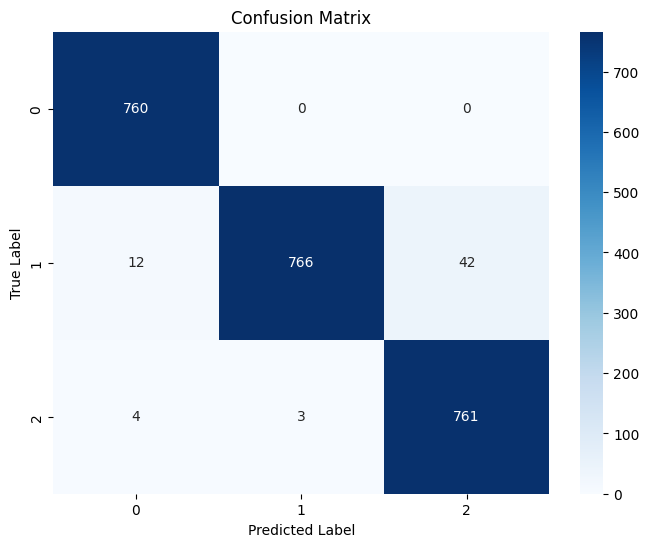

In [48]:
# Create the validation confusion matrix
cm = confusion_matrix(val_results['expected_label'], val_results['predicted_label'],labels=["ENTAILMENT","NEUTRAL","CONTRADICTION"])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [49]:
val_results[val_results['expected_label'] != val_results['predicted_label']]

,id,premise,hypothesis,expected_label,predicted_label
2188,2188,"If the president has a talented brother, he'll coach his talented brother.",The president did not coach his talented brother.,NEUTRAL,CONTRADICTION
2189,2189,"It's not the case that if the president has a talented brother, he'll coach his talented brother.",The president did not coach his talented brother.,NEUTRAL,CONTRADICTION
2190,2190,"Sam believes that if the president has a talented brother, he'll coach his talented brother.",The president did not coach his talented brother.,NEUTRAL,CONTRADICTION
2191,2191,"Is it true that if the president has a talented brother, he'll coach his talented brother?",The president did not coach his talented brother.,NEUTRAL,CONTRADICTION
2192,2192,"If the president has a talented brother, he'll coach his talented brother.",The president does coach his talented brother.,CONTRADICTION,ENTAILMENT
...,...,...,...,...,...
2336,2336,"Is it true that if Mia's car breaks down, her coworker will give her a ride to the office?",Mia has a supportive coworker.,NEUTRAL,ENTAILMENT
2338,2338,"If Scarlett finishes her exam early, her friend will take her out for lunch.",Scarlett has a generous friend.,NEUTRAL,ENTAILMENT
2339,2339,"It's not the case that if Scarlett finishes her exam early, her friend will take her out for lunch.",Scarlett has a generous friend.,NEUTRAL,ENTAILMENT
2340,2340,"Sam believes that if Scarlett finishes her exam early, her friend will take her out for lunch.",Scarlett has a generous friend.,NEUTRAL,ENTAILMENT


In [62]:
id_num = 0
test_results = pd.DataFrame(columns = ['id', 'premise', 'hypothesis', 'type', 'expected_label', 'predicted_label'])

for predicted in gen(KeyPairDataset(test_ds,'premise', 'hypothesis'), batch_size=8, truncation=True):
    if id_num % 100 == 0:
        print(id_num)
    test_results.loc[id_num] = [str(id_num), test_ds['premise'][id_num], test_ds['hypothesis'][id_num], test_ds['type'][id_num], test_ds['label'][id_num], predicted['label']]
    id_num += 1

len(test_results)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


2367

In [46]:
test_results

,id,premise,hypothesis,type,expected_label,predicted_label
0,0,"If Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,type5_possessive,ENTAILMENT,ENTAILMENT
1,1,"It's not the case that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,type5_possessive,ENTAILMENT,ENTAILMENT
2,2,"Sam believes that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,type5_possessive,ENTAILMENT,ENTAILMENT
3,3,"Is it true that if Jessica attends the conference, her colleague will meet her at the hotel?",Jessica has a colleague.,type5_possessive,ENTAILMENT,ENTAILMENT
4,4,"If Mia's car breaks down, her coworker will give her a ride to the office.",Mia has a coworker.,type5_possessive,ENTAILMENT,ENTAILMENT
...,...,...,...,...,...,...
2163,2163,"If Andrew arrives early, he'll never express a deep conviction again.",Andrew has not expressed a deep conviction before.,type5_possessive,CONTRADICTION,CONTRADICTION
2164,2164,"If Barbara finishes her project on time, she'll never enhance a backyard again.",Barbara has not enhanced a backyard before.,type5_possessive,CONTRADICTION,CONTRADICTION
2165,2165,"If Andrew travels to London, he'll never raise a toast to celebrate his birthday again.",Andrew has not raised a toast to celebrate his birthday before.,type5_possessive,CONTRADICTION,CONTRADICTION
2166,2166,"If Dorothy's car breaks down, she'll never obtain a job position again.",Dorothy has not obtained a job position before.,type5_possessive,CONTRADICTION,CONTRADICTION


In [63]:
test_results.to_csv('exp5_deberta_test_results_new_run3.csv')

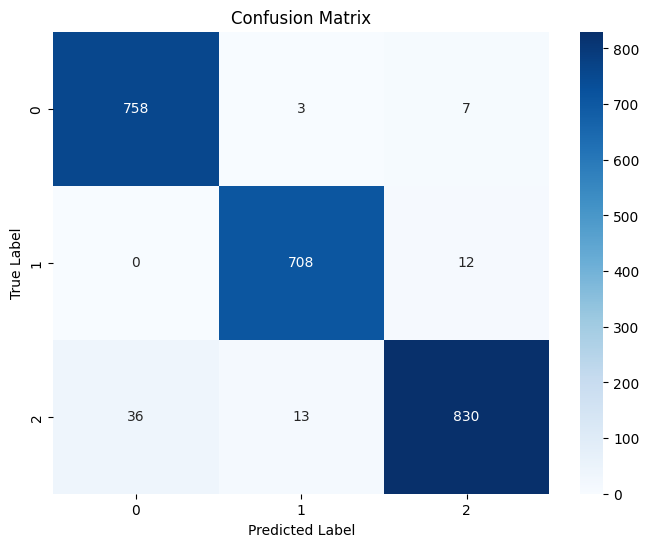

In [64]:
# Create the testing confusion matrix
cm = confusion_matrix(test_results['expected_label'], test_results['predicted_label'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [65]:
report_dict = classification_report(test_results['expected_label'], test_results['predicted_label'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose() 
report_df.columns.name = 'label'
report_df

label,precision,recall,f1-score,support
CONTRADICTION,0.954660,0.986979,0.970551,768.000000
ENTAILMENT,0.977901,0.983333,0.980609,720.000000
NEUTRAL,0.977621,0.944255,0.960648,879.000000
accuracy,0.970004,0.970004,0.970004,0.970004
macro avg,0.970060,0.971522,0.970603,2367.000000
weighted avg,0.970256,0.970004,0.969933,2367.000000


In [66]:
metrics_by_type = test_results.groupby('type').apply(compute_metrics_by_type).reset_index()
metrics_by_type.columns.name = 'ID'
metrics_by_type

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-66-823762390d06>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_type = test_res

ID,type,accuracy,precision,recall,f1_score
0,type1_again,1.00,1.00,1.00,1.00
1,type1_possessive,0.91,0.90,0.91,0.90
2,type2_again,0.99,0.99,0.99,0.99
3,type2_possessive,0.99,0.98,0.99,0.98
4,type3_again,0.94,0.99,0.94,0.96
5,type3_possessive,1.00,1.00,1.00,1.00
6,type4_possessive,0.98,0.99,0.98,0.98
7,type5_again,0.94,0.95,0.94,0.95
8,type5_possessive,0.98,0.99,0.98,0.98


## new tests

In [18]:
id_num = 0
new_test_results = pd.DataFrame(columns = ['id', 'premise', 'hypothesis', 'type', 'expected_label', 'predicted_label'])

for predicted in gen(KeyPairDataset(new_test_ds,'premise', 'hypothesis'), batch_size=8, truncation=True):
    if id_num % 100 == 0:
        print(id_num)
    new_test_results.loc[id_num] = [str(id_num), new_test_ds['premise'][id_num], new_test_ds['hypothesis'][id_num], new_test_ds['type'][id_num], new_test_ds['label'][id_num], predicted['label']]
    id_num += 1

len(new_test_results)

0


28

In [19]:
new_test_results

,id,premise,hypothesis,type,expected_label,predicted_label
0,0,Jessica's colleague will meet her at the hotel...,Jessica has a colleague.,type5_possessive,ENTAILMENT,ENTAILMENT
1,1,It's not the case that Jessica's colleague wil...,Jessica has a colleague.,type5_possessive,ENTAILMENT,ENTAILMENT
2,2,Sam believes that Jessica's colleague will mee...,Jessica has a colleague.,type5_possessive,ENTAILMENT,ENTAILMENT
3,3,Is it true tha tJessica's colleague will meet ...,Jessica has a colleague.,type5_possessive,ENTAILMENT,ENTAILMENT
4,4,Tiffany will bring her essential oils kit to t...,Tiffany has an essential oils kit.,type4_possessive,ENTAILMENT,ENTAILMENT
5,5,It's not the case that Tiffany will bring her ...,Tiffany has an essential oils kit.,type4_possessive,ENTAILMENT,ENTAILMENT
6,6,Sam believes that Tiffany will bring her essen...,Tiffany has an essential oils kit.,type4_possessive,ENTAILMENT,ENTAILMENT
7,7,Is it true that Tiffany will bring her essenti...,Tiffany has an essential oils kit.,type4_possessive,ENTAILMENT,ENTAILMENT
8,8,Andrew will never express a deep convistion ag...,Andrew has expressed a deep conviction before.,type5_again,ENTAILMENT,ENTAILMENT
9,9,It's not the case that Andrew will never expre...,Andrew has expressed a deep conviction before.,type5_again,ENTAILMENT,ENTAILMENT


# hard tests 

In [16]:
id_num = 0
hard_test_results = pd.DataFrame(columns = ['id', 'premise', 'hypothesis', 'type', 'expected_label', 'predicted_label'])

for predicted in gen(KeyPairDataset(hard_test_ds,'premise', 'hypothesis'), batch_size=8, truncation=True):
    if id_num % 100 == 0:
        print(id_num)
    hard_test_results.loc[id_num] = [str(id_num), hard_test_ds['premise'][id_num], hard_test_ds['hypothesis'][id_num], hard_test_ds['type'][id_num], hard_test_ds['label'][id_num], predicted['label']]
    id_num += 1

len(hard_test_results)

0


21

In [17]:
hard_test_results

,id,premise,hypothesis,type,expected_label,predicted_label
0,0,"If Jessica attends the conference, her colleag...",Jessica has a sister.,type5_possessive,NEUTRAL,ENTAILMENT
1,1,It's not the case that if Jessica attends the ...,Jessica has a sister.,type5_possessive,NEUTRAL,ENTAILMENT
2,2,Sam believes that if Jessica attends the confe...,Jessica has a sister.,type5_possessive,NEUTRAL,ENTAILMENT
3,3,Is it true that if Jessica attends the confere...,Jessica has a sister.,type5_possessive,NEUTRAL,ENTAILMENT
4,4,"If Mia's car breaks down, she'll never write a...",Mia wrote a horror novel again.,type5_again,NEUTRAL,CONTRADICTION
5,5,It's not the case that if Mia's car breaks dow...,Mia wrote a horror novel again.,type5_again,NEUTRAL,CONTRADICTION
6,6,"Sam believes that if Mia's car breaks down, sh...",Mia wrote a horror novel again.,type5_again,NEUTRAL,CONTRADICTION
7,7,"Is it true that if Mia's car breaks down, she'...",Mia wrote a horror novel again.,type5_again,NEUTRAL,CONTRADICTION
8,8,"If the teacher watched a movie by Nolan, she'l...",The teacher did not watch a movie by Nolan,type1_again,NEUTRAL,CONTRADICTION
9,9,"If Angela wrote a horror novel, she'll never w...",Angela did not write a horror novel.,type1_again,NEUTRAL,CONTRADICTION


In [18]:
hard_test_results.to_csv('hard_test_results.csv')

## FacebookAI/roberta-large-mnli

In [82]:
checkpoint = "FacebookAI/roberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [83]:
tokenized_train_ds = train_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
tokenized_val_ds = val_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6486 [00:00<?, ? examples/s]

Map:   0%|          | 0/2348 [00:00<?, ? examples/s]

In [29]:
len(val_ds)

2168

In [84]:
random_seed = random.randint(0, 2**32 - 1)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1, # Set the number of epochs to 1
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    # evaluation_strategy="epoch",  # Evaluate during training
    # evaluation_strategy="no",
    save_strategy="epoch",  # Save the model at the end of each epoch
    # load_best_model_at_end=True,  # Load the best model at the end of training
    report_to="none",
    seed=random_seed
)
trainer = Trainer(
    model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_val_ds,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[]
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-84-84be40e1fc9f>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [85]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
100,0.091900,0.339538,0.956985,0.958425,0.956985,0.956693,0.967844
200,0.047700,0.285400,0.955707,0.957470,0.955707,0.955445,0.966880
300,0.039100,0.282230,0.957836,0.959023,0.957836,0.957595,0.968450
400,0.019500,0.223497,0.968910,0.969237,0.968910,0.968812,0.976650


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=406, training_loss=0.048832890108512175, metrics={'train_runtime': 1661.2135, 'train_samples_per_second': 3.904, 'train_steps_per_second': 0.244, 'total_flos': 6044527245662208.0, 'train_loss': 0.048832890108512175, 'epoch': 1.0})

In [70]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
100,0.099600,0.303535,0.959540,0.960719,0.959540,0.959359,0.969676
200,0.045700,0.248404,0.958688,0.961505,0.958688,0.958663,0.969211
300,0.043700,0.171733,0.964225,0.965850,0.964225,0.963900,0.973400
400,0.018000,0.186670,0.959966,0.962769,0.959966,0.960065,0.970160


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=406, training_loss=0.051662018586849344, metrics={'train_runtime': 1663.3236, 'train_samples_per_second': 3.899, 'train_steps_per_second': 0.244, 'total_flos': 6044527245662208.0, 'train_loss': 0.051662018586849344, 'epoch': 1.0})

In [33]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
100,0.134500,0.347984,0.950596,0.951530,0.950596,0.950369,0.962905
200,0.027400,0.331316,0.952300,0.953408,0.952300,0.952303,0.964194
300,0.010100,0.307603,0.962947,0.962970,0.962947,0.962869,0.972110
400,0.031800,0.276054,0.966780,0.966882,0.966780,0.966762,0.974978


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=406, training_loss=0.05021810696891559, metrics={'train_runtime': 1657.8101, 'train_samples_per_second': 3.912, 'train_steps_per_second': 0.245, 'total_flos': 6044527245662208.0, 'train_loss': 0.05021810696891559, 'epoch': 1.0})

In [87]:
trainer.save_model("roberta")

In [ ]:
# uploading to HuggingFace 
from huggingface_hub import login

login(new_session=False, # Won’t request token if one is already saved on machine
write_permission=True, # Requires a token with write permission
token="", # The name of your token
add_to_git_credential=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'login': write_permission. Will not be supported from version '1.0'.

Fine-grained tokens added complexity to the permissions, making it irrelevant to check if a token has 'write' access.
  warnings.warn(message, FutureWarning)
Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [88]:
from huggingface_hub import HfApi
api = HfApi()

# Upload all the content from the local folder to your remote Space.
# By default, files are uploaded at the root of the repo
api.upload_folder(
    folder_path='/kaggle/working/roberta',
    repo_id="ConditionalNLI/Exp5_roberta-large-mnli",
    commit_message="Run 3"
)

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/ConditionalNLI/Exp5_roberta-large-mnli/commit/4091ef04ed668debdf54e2bcc5c785af5fb23a6f', commit_message='Run 3', commit_description='', oid='4091ef04ed668debdf54e2bcc5c785af5fb23a6f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ConditionalNLI/Exp5_roberta-large-mnli', endpoint='https://huggingface.co', repo_type='model', repo_id='ConditionalNLI/Exp5_roberta-large-mnli'), pr_revision=None, pr_num=None)

### Inferencing

In [89]:
from transformers import pipeline
from datasets import load_dataset, Dataset
from transformers.pipelines.pt_utils import KeyDataset, KeyPairDataset
import torch

In [90]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available!


In [91]:
# loading model
model = AutoModelForSequenceClassification.from_pretrained('ConditionalNLI/Exp5_roberta-large-mnli',num_labels=3).to(device)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [92]:
gen = pipeline('text-classification', model=model, tokenizer=tokenizer, device=device)

Device set to use cuda


In [93]:
id_num = 0
test_results = pd.DataFrame(columns = ['id', 'premise', 'hypothesis', 'type', 'expected_label', 'predicted_label'])

for predicted in gen(KeyPairDataset(test_ds,'premise', 'hypothesis'), batch_size=8, truncation=True):
    if id_num % 100 == 0:
        print(id_num)
    test_results.loc[id_num] = [str(id_num), test_ds['premise'][id_num], test_ds['hypothesis'][id_num], test_ds['type'][id_num], test_ds['label'][id_num], predicted['label']]
    id_num += 1

len(test_results)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


2367

In [39]:
test_results

,id,premise,hypothesis,type,expected_label,predicted_label
0,0,"If Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,type5_possessive,ENTAILMENT,ENTAILMENT
1,1,"It's not the case that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,type5_possessive,ENTAILMENT,ENTAILMENT
2,2,"Sam believes that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,type5_possessive,ENTAILMENT,ENTAILMENT
3,3,"Is it true that if Jessica attends the conference, her colleague will meet her at the hotel?",Jessica has a colleague.,type5_possessive,ENTAILMENT,ENTAILMENT
4,4,"If Mia's car breaks down, her coworker will give her a ride to the office.",Mia has a coworker.,type5_possessive,ENTAILMENT,ENTAILMENT
...,...,...,...,...,...,...
2163,2163,"If Andrew arrives early, he'll never express a deep conviction again.",Andrew has not expressed a deep conviction before.,type5_possessive,CONTRADICTION,CONTRADICTION
2164,2164,"If Barbara finishes her project on time, she'll never enhance a backyard again.",Barbara has not enhanced a backyard before.,type5_possessive,CONTRADICTION,CONTRADICTION
2165,2165,"If Andrew travels to London, he'll never raise a toast to celebrate his birthday again.",Andrew has not raised a toast to celebrate his birthday before.,type5_possessive,CONTRADICTION,CONTRADICTION
2166,2166,"If Dorothy's car breaks down, she'll never obtain a job position again.",Dorothy has not obtained a job position before.,type5_possessive,CONTRADICTION,CONTRADICTION


In [94]:
test_results.to_csv('exp5-roberta_test_results_run3.csv')

In [95]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

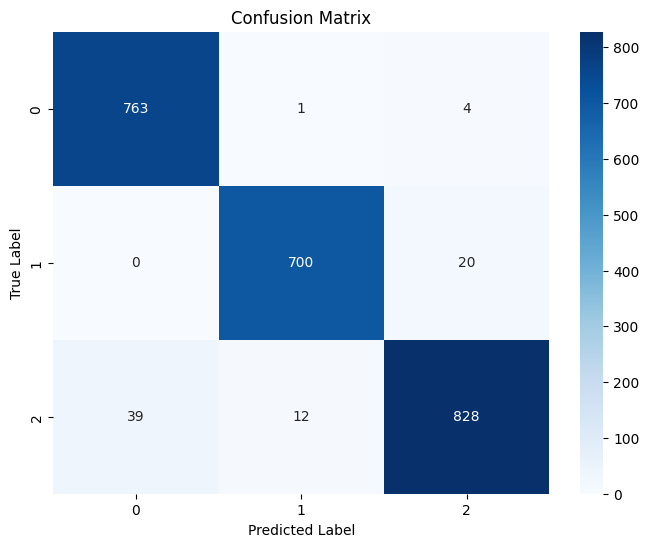

In [96]:
# Create the testing confusion matrix
cm = confusion_matrix(test_results['expected_label'], test_results['predicted_label'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [98]:
report_dict = classification_report(test_results['expected_label'], test_results['predicted_label'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose() 
report_df.columns.name = 'label'
report_df

label,precision,recall,f1-score,support
CONTRADICTION,0.951372,0.993490,0.971975,768.000000
ENTAILMENT,0.981767,0.972222,0.976971,720.000000
NEUTRAL,0.971831,0.941980,0.956672,879.000000
accuracy,0.967892,0.967892,0.967892,0.967892
macro avg,0.968323,0.969230,0.968539,2367.000000
weighted avg,0.968215,0.967892,0.967812,2367.000000


In [99]:
metrics_by_type = test_results.groupby('type').apply(compute_metrics_by_type).reset_index()
metrics_by_type.columns.name = 'ID'
metrics_by_type

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-99-823762390d06>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This be

ID,type,accuracy,precision,recall,f1_score
0,type1_again,0.99,0.99,0.99,0.99
1,type1_possessive,0.90,0.91,0.90,0.90
2,type2_again,1.00,1.00,1.00,1.00
3,type2_possessive,0.99,0.99,0.99,0.99
4,type3_again,0.92,1.00,0.92,0.96
5,type3_possessive,1.00,1.00,1.00,1.00
6,type4_possessive,0.98,0.99,0.98,0.98
7,type5_again,0.95,1.00,0.95,0.96
8,type5_possessive,0.97,0.98,0.97,0.97
